In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

In [3]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')

In [4]:
df.head()

HotelId,DOA,DBA,ROH_max,ROH_min,ROH_med,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std
0,2018-01-01,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.5,38.69,72.9,75.847778,30.871318
1,2018-01-01,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.5,38.69,72.9,75.847778,30.871318
2,2018-01-01,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.5,38.69,72.9,75.847778,30.871318
3,2018-01-01,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.5,38.69,72.9,75.847778,30.871318
4,2018-01-01,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.5,38.69,72.9,75.847778,30.871318


In [5]:
df = df[df['DBA']==0]
df = df.rename(columns={'ROH_med':'ROH'})
df = df[['DOA','ROH']]
df = df.set_index('DOA')
df = df.asfreq(freq='d', method='ffill')
train = df[:'2019-09-30']
test  = df['2019-09-30':]

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HotelId,,,,,,,,
ROH,730.0,19.208904,11.345575,2.0,10.5,17.5,25.0,68.0


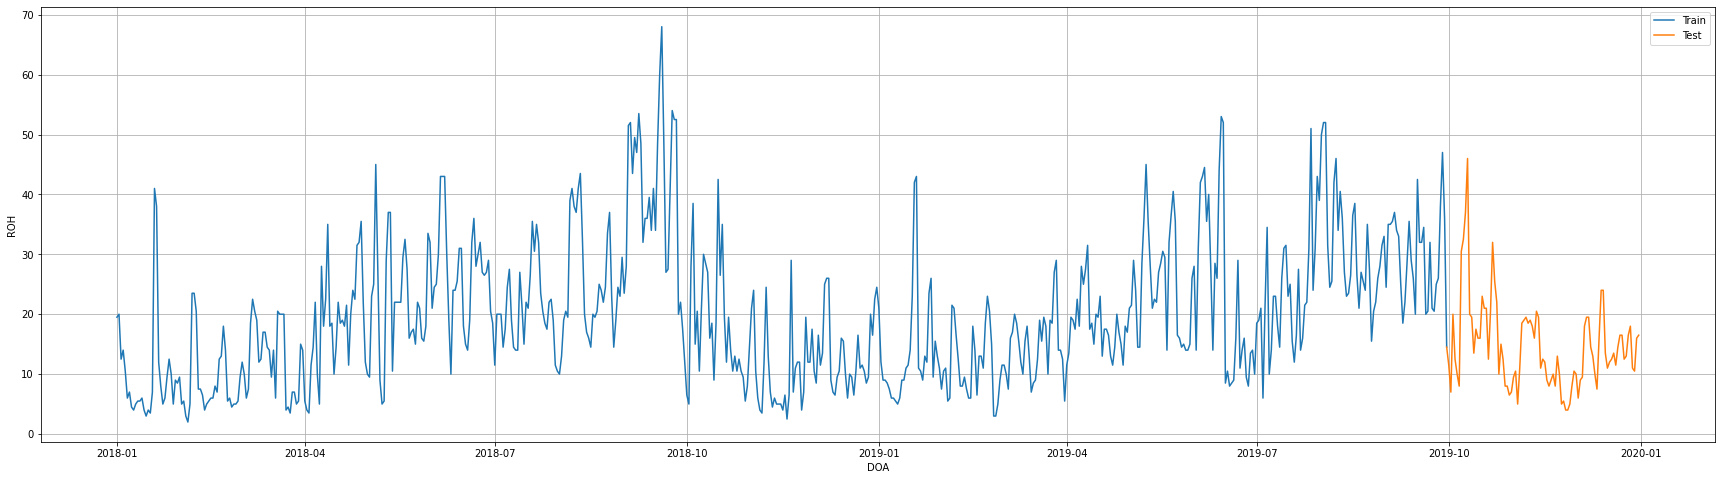

In [7]:
plt.plot(train.index, train['ROH'], label='Train')
plt.plot(test.index, test['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

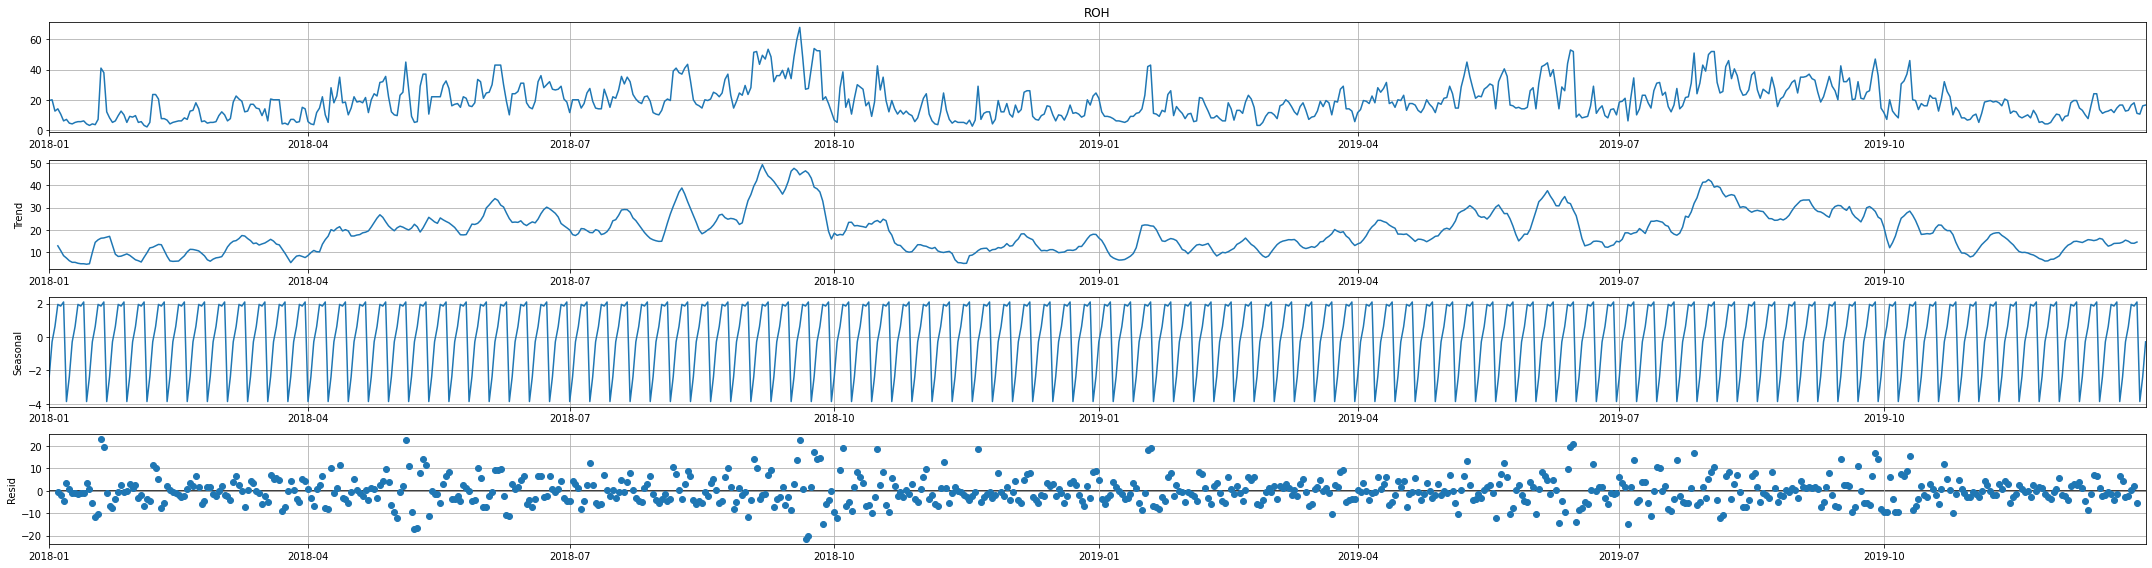

In [8]:
sm.tsa.seasonal_decompose(df.ROH).plot()
result = sm.tsa.stattools.adfuller(df.ROH)
plt.show()

Check if time serise is stationary:
- You need differencing only if series is non-stationary. You can check that if the P Value > 0.05 we go ahead with finding the order of differencing. 
- Else, no differencing is needed, that is, d=0.

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train.ROH.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Test: ' ,result[1]>0.05)

ADF Statistic: -3.123065
p-value: 0.024893
Test:  False


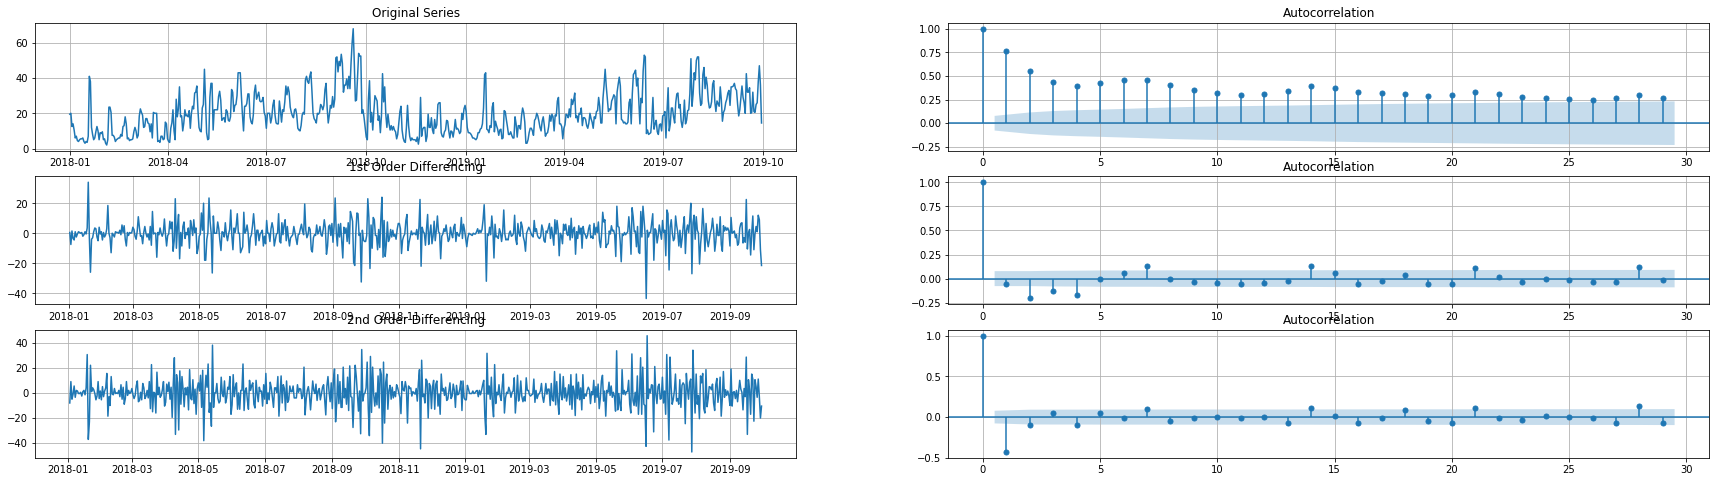

In [10]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(train.ROH) 
axes[0, 0].set_title('Original Series')
plot_acf(train.ROH, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.ROH.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.ROH.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.ROH.diff().diff()) 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.ROH.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [11]:
# 1,1,2 ARIMA Model
model = ARIMA(train.ROH, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2174.702
Method:                       css-mle   S.D. of innovations              7.347
Date:                Thu, 14 Jan 2021   AIC                           4359.404
Time:                        07:23:50   BIC                           4381.688
Sample:                    01-02-2018   HQIC                          4368.056
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0269      0.047      0.577      0.564      -0.064       0.118
ar.L1.D.ROH     0.4239      0.071      5.970      0.000       0.285       0.563
ma.L1.D.ROH    -0.6556      0.073     -8.981    

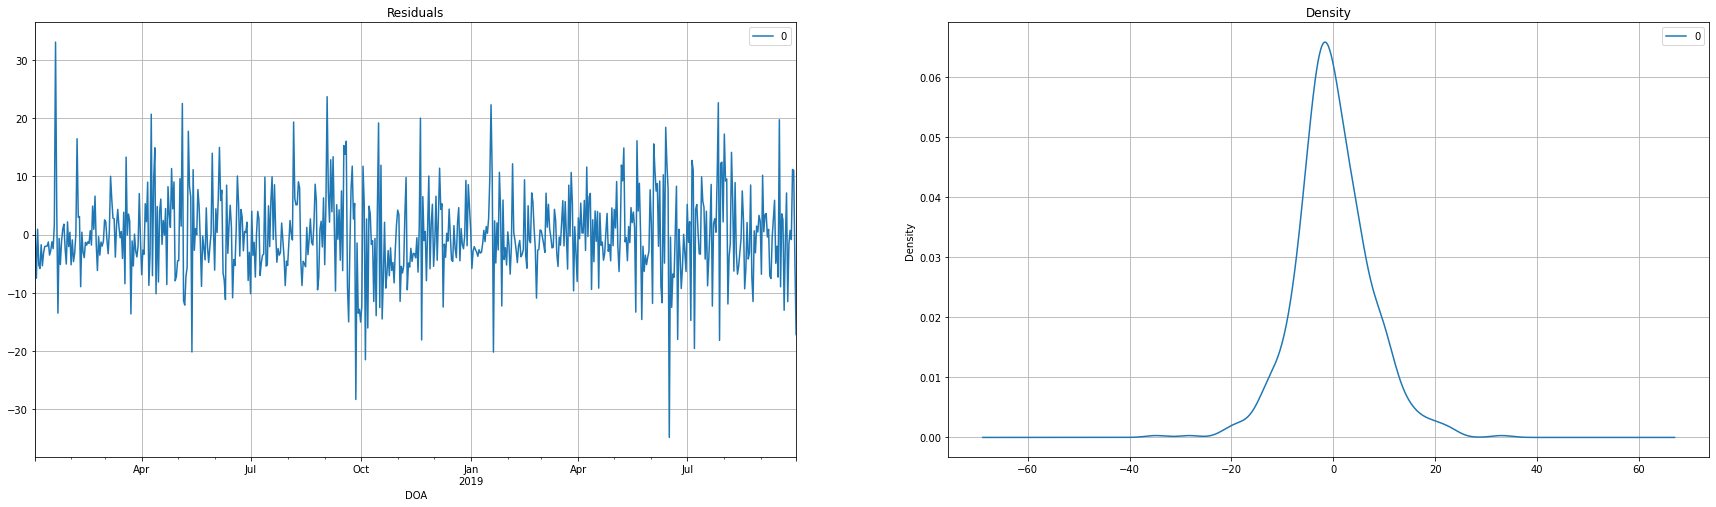

In [12]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

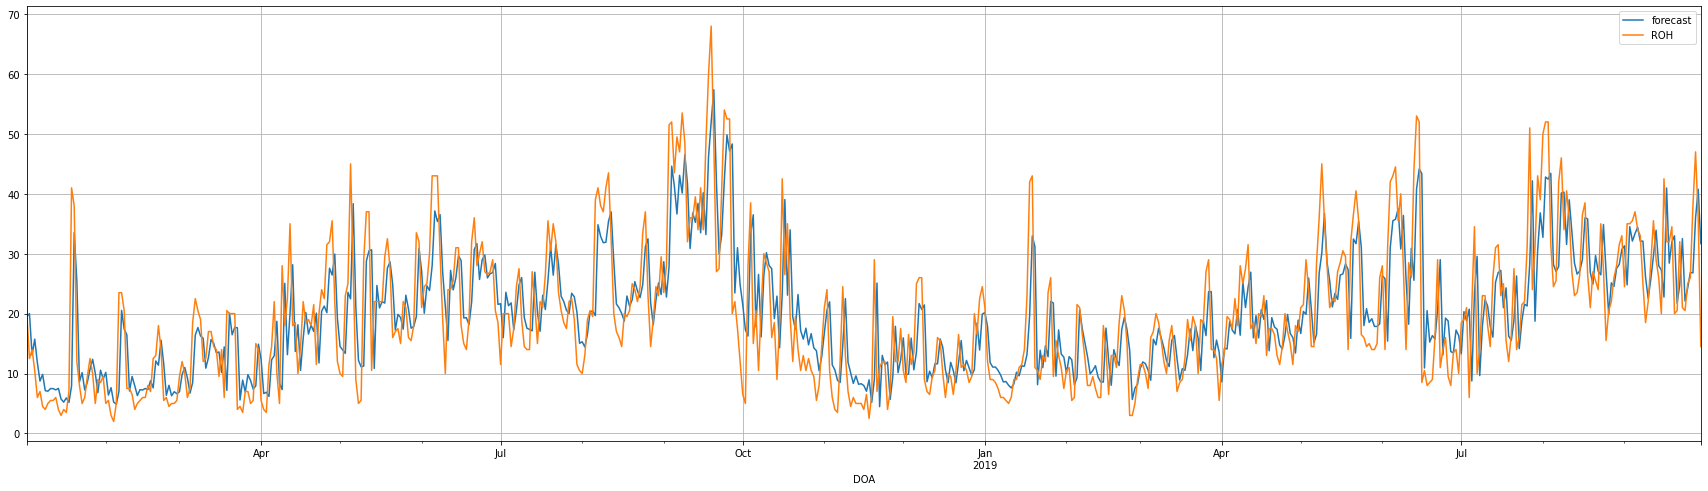

In [13]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [14]:
model = pm.auto_arima(train.ROH, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4462.435, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5815.577, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4461.211, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5193.338, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4462.759, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4459.863, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4366.322, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4441.760, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4382.947, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4368.170, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4361.839, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4394.421, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4394.146, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4362.787, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

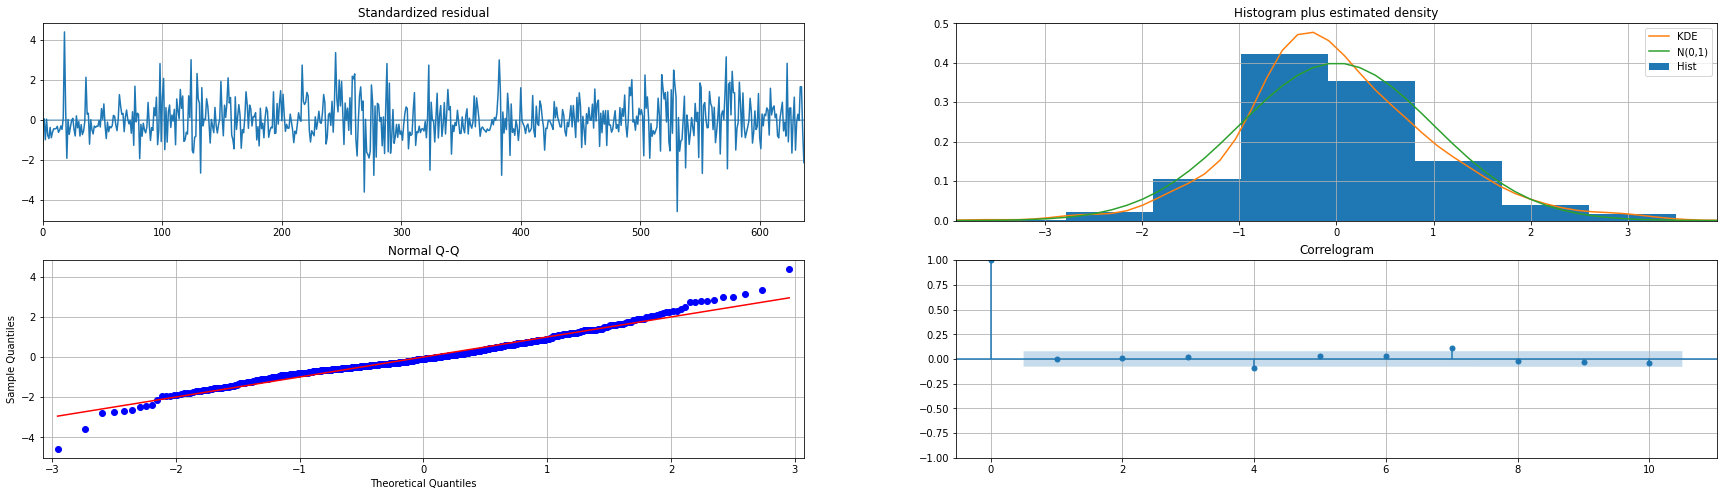

In [15]:
model.plot_diagnostics()
plt.show()

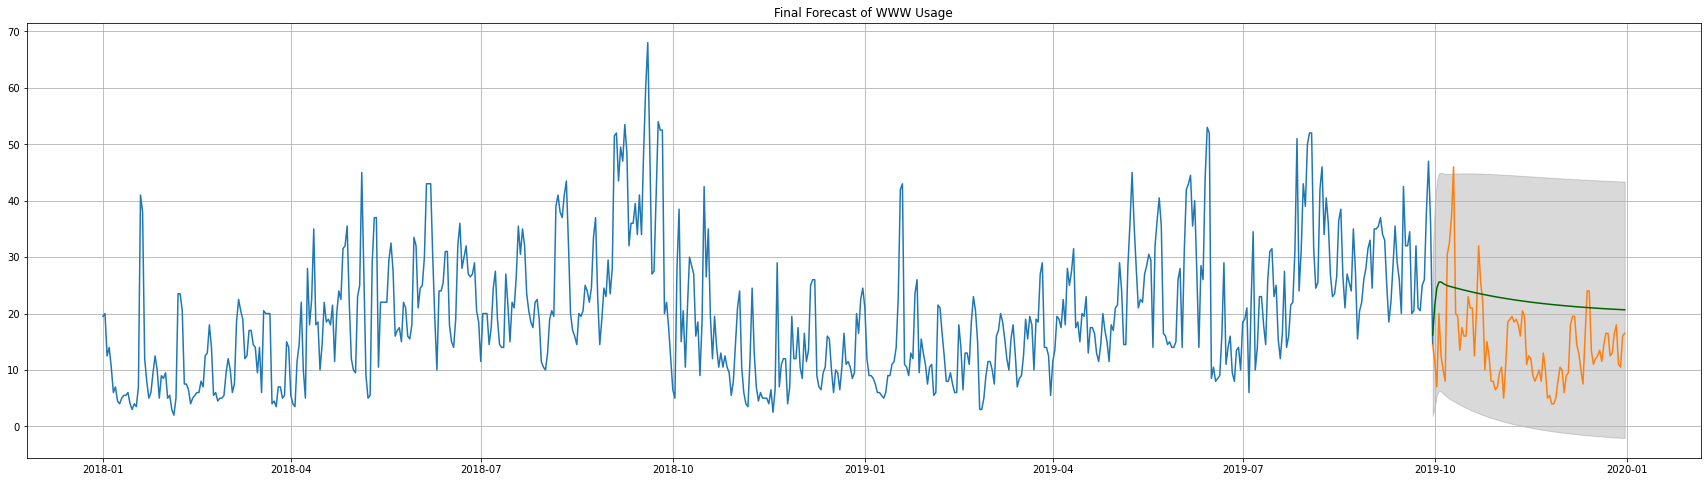

In [16]:
# Forecast
n_periods = 93
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index #np.arange(len(train.ROH), len(train.ROH)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.ROH)
plt.plot(test)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [17]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}) #, 'acf1':acf1, 'corr':corr, 'minmax':minmax

In [18]:
forecast_accuracy(fc_series.values,test.values)

{'mape': 0.9670623323832062,
 'me': 7.660316248023262,
 'mae': 9.285043485860037,
 'mpe': 0.9202285658841552,
 'rmse': 10.633871283518555}

# SARIMA

In [19]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4399.561, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4949.035, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4402.101, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4544.222, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5815.577, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4397.918, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=4399.523, Time=0.50 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4399.468, Time=1.27 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4565.143, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4400.119, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4394.421, Time=0.29 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=4396.123, Time=0.99 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=4396.149, Time=0.89 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=4396.525, Time=1.24 sec
 ARIMA(2,0,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  638
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -2174.919
Date:                Thu, 14 Jan 2021   AIC                           4361.839
Time:                        07:24:10   BIC                           4388.589
Sample:                             0   HQIC                          4372.223
                                - 638                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2144      0.151      1.424      0.154      -0.081       0.510
ar.L1          1.6501      0.049     33.571      0.000       1.554       1.746
ar.L2         -0.8511      0.065    -13.042      0.000      -0.979      -0.723
ar.L3          0.1901      0.038      4.955      0.000       0.115       0.265
ma.L1         -0.8833      0.037    -23.909      0.000      -0.956      -0.811
sigma2        53.4137      2.539     21.038      0.000      48.438      58.390
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                85.42
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.26
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

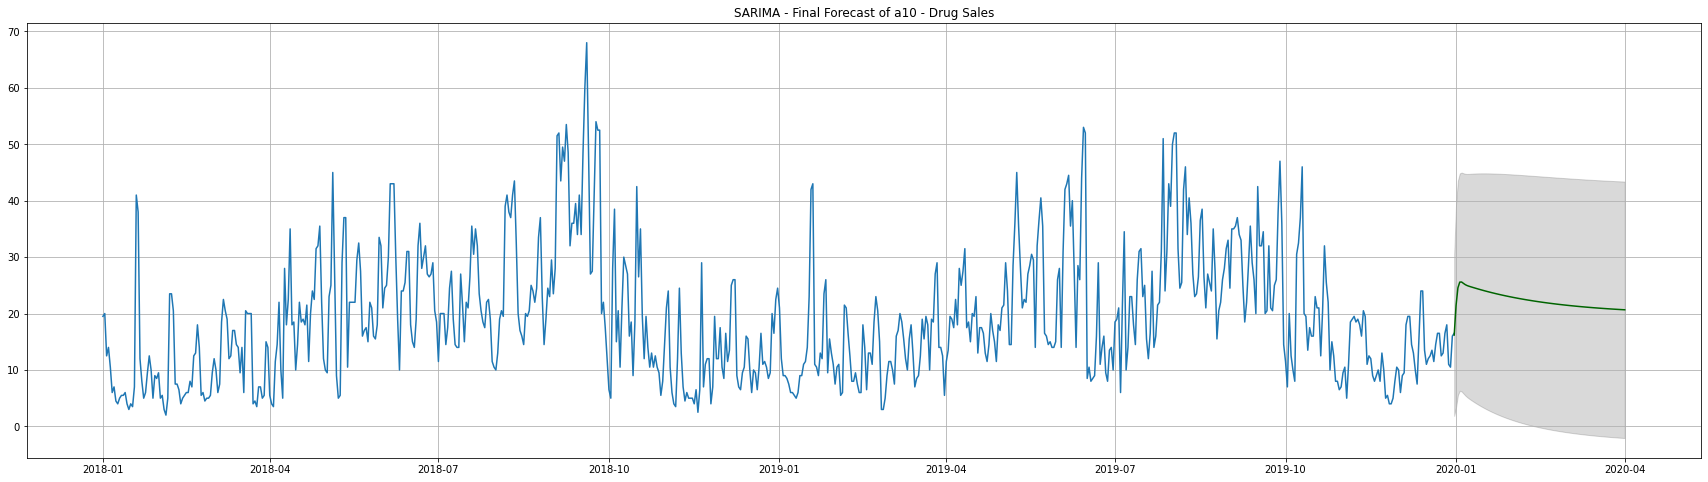

In [20]:
# Forecast
n_periods = 93
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='d')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()